This notebook is for hyperparameter optimization on the two basline CNN models: 

    3 x ([Conv --> Batchnorm --> ReLU] x N) --> FC --> Softmax 
    3 x ([Conv --> Batchnorm --> ReLU] x N) --> [Conv --> Batchnorm --> ReLU] x M --> FC --> Softmax

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import ThreeCNN, ThreeCNN_Module 
from train import check_accuracy, train, train_ThreeCNN
from plottingFcts import trainingMetrics, sigBkgEff, plotROC

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In [3]:
# establish network dimensions 
layer0_params = [1, 3, 3, 1, 1]
layer0_reduce = [1, 3, 93, 1, 1]

layer1_params = [1, 3, 3, 1, 1]
layer1_reduce = [1, 12, 9, 1, 1]

layer2_params = [1, 3, 3, 1, 1]
layer2_reduce = [1, 12, 3, 1, 1]

fc_params = [54, 150, 100, 50, 3, 0.5]

In [9]:
# trying out the module API network
# in this case we use flag = False 
module_test = ThreeCNN_Module(layer0_params, layer0_reduce, layer1_params, layer1_reduce, layer2_params, layer2_reduce, fc_params)

optimizer = optim.Adam(module_test.parameters())

# train the network for one epoch 
hist, bestModel = train(loader_train, loader_val, module_test, optimizer, epochs=2, returnBest=True)


Epoch 1/2:
Iteration 0, loss = 1.1043
Got 10346 / 30000 correct (34.49)

Iteration 100, loss = 0.7236
Got 19941 / 30000 correct (66.47)

Iteration 200, loss = 0.5240
Got 20848 / 30000 correct (69.49)

Iteration 300, loss = 0.6293
Got 21272 / 30000 correct (70.91)

Iteration 400, loss = 0.5410
Got 21362 / 30000 correct (71.21)

Iteration 500, loss = 0.5704
Got 21330 / 30000 correct (71.10)

Iteration 600, loss = 0.5287
Got 21562 / 30000 correct (71.87)

Iteration 700, loss = 0.5004
Got 21578 / 30000 correct (71.93)

Got 129719 / 180000 correct (72.07)
Got 21647 / 30000 correct (72.16)

Epoch 2/2:
Iteration 0, loss = 0.5985
Got 21689 / 30000 correct (72.30)

Iteration 100, loss = 0.4814
Got 21734 / 30000 correct (72.45)

Iteration 200, loss = 0.4883
Got 21514 / 30000 correct (71.71)

Iteration 300, loss = 0.4581
Got 21795 / 30000 correct (72.65)

Iteration 400, loss = 0.4756
Got 21886 / 30000 correct (72.95)

Iteration 500, loss = 0.4945
Got 21977 / 30000 correct (73.26)

Iteration 600,

In [ ]:
trainingMetrics(hist)

Min / max of y_test
0 2
(30000,)
-40.627163 9.989752


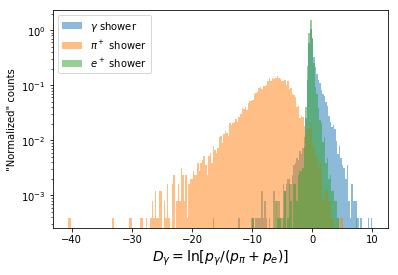

../plottingFcts.py:213: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


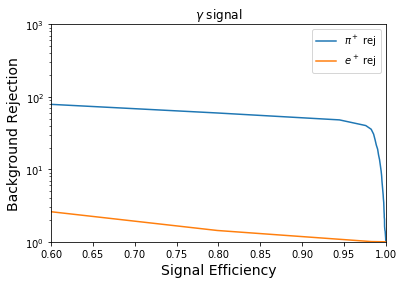

Min / max of y_test
0 2
(30000,)
-16.440784 35.379276


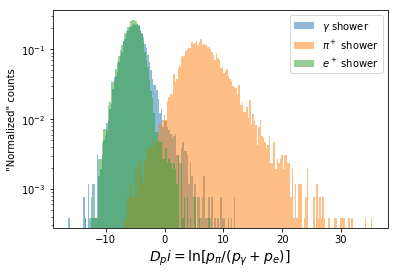

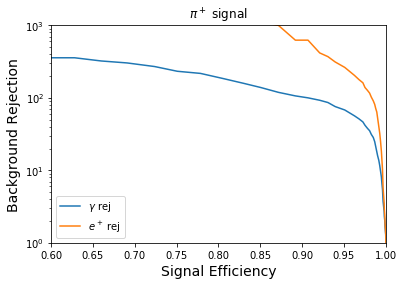

Min / max of y_test
0 2
(30000,)
-47.578865 1.3980849


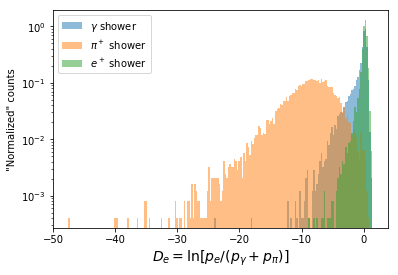

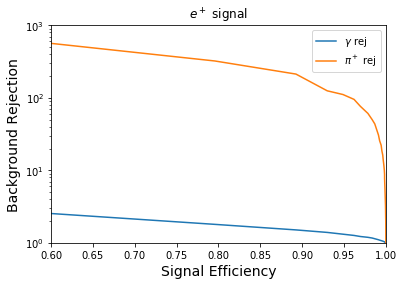

In [15]:
# get ROC curves for model 
for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(module_test, loader_val, node)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal')
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal')
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal')

The second model, which adds a CNN preprocessing layer between the three initial CNN layers and the fc layer. 

In [13]:
# parameters for the additional CNN layer 
layer3_params = [3, 3, 3, 1, 1]

module_preprocessTest = ThreeCNN_Module(layer0_params, layer0_reduce, layer1_params, layer1_reduce, layer2_params, layer2_reduce, fc_params, layer3_params=layer3_params, flag=True)

optimizer = optim.Adam(module_preprocessTest.parameters())

# train the network for one epoch 
hist, bestModel = train(loader_train, loader_val, module_preprocessTest, optimizer, epochs=2, returnBest=True)


Epoch 1/2:
Iteration 0, loss = 1.1759
Got 9953 / 30000 correct (33.18)

Iteration 100, loss = 0.7861
Got 18885 / 30000 correct (62.95)

Iteration 200, loss = 0.6242
Got 20499 / 30000 correct (68.33)

Iteration 300, loss = 0.5953
Got 20987 / 30000 correct (69.96)

Iteration 400, loss = 0.5108
Got 21282 / 30000 correct (70.94)

Iteration 500, loss = 0.4947
Got 21424 / 30000 correct (71.41)

Iteration 600, loss = 0.4745
Got 21656 / 30000 correct (72.19)

Iteration 700, loss = 0.5439
Got 21654 / 30000 correct (72.18)

Got 129608 / 180000 correct (72.00)
Got 21486 / 30000 correct (71.62)

Epoch 2/2:
Iteration 0, loss = 0.5038
Got 21510 / 30000 correct (71.70)

Iteration 100, loss = 0.4595
Got 21627 / 30000 correct (72.09)

Iteration 200, loss = 0.5190
Got 21756 / 30000 correct (72.52)

Iteration 300, loss = 0.5146
Got 21807 / 30000 correct (72.69)

Iteration 400, loss = 0.4785
Got 21757 / 30000 correct (72.52)

Iteration 500, loss = 0.4835
Got 21953 / 30000 correct (73.18)

Iteration 600, 

This additional CNN preprocessing layer performed very slightly better than the original model. Hyperparameter optimization should increase this gap, as will adding more layers to the intermediate layer. 